# Land Type Classification using Sentinel-2 Satellite Images
### **VGG16 Edition**
***

#### Some tests for GPU `tensorflow`

In [1]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))


2.10.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from tensorflow.python.platform.build_info import build_info

print("CUDA:", build_info["cuda_version"])
print("cuDNN:", build_info["cudnn_version"])

CUDA: 64_112
cuDNN: 64_8


#### Limited VRAM usage as CUDA allocate the whole entirety of VRAM

In [3]:
# from tensorflow.config.experimental import list_physical_devices, VirtualDeviceConfiguration, set_virtual_device_configuration #type:ignore
# vram_GB = 2 
# gpus = list_physical_devices('GPU')
# if gpus:
#     try:
#         set_virtual_device_configuration( gpus[0], [VirtualDeviceConfiguration(memory_limit= vram_GB * 1024)] )
#         print(f"[/] Limited GPU memory to {vram_GB} GB.")
#     except RuntimeError as e:
#         print(e)

### Had to re-define `CategoricalFocalLoss` as it was missing in this old version of tensorflow
 - should have the same functionanlity

In [4]:
import tensorflow as tf
from tensorflow.keras.losses import Loss #type:ignore
from tensorflow.keras import backend as K #type:ignore

class CategoricalFocalLoss(Loss):
    """
    Categorical focal loss for one-hot labels.
    Usage:
        loss = CategoricalFocalLoss(gamma=2.0, alpha=0.25)
        model.compile(..., loss=loss, ...)
    """
    def __init__(self, gamma=2.0, alpha=0.25, from_logits=False, reduction=tf.keras.losses.Reduction.AUTO, name="categorical_focal_loss"):
        super().__init__(reduction=reduction, name=name)
        self.gamma = float(gamma)
        self.alpha = float(alpha) if alpha is not None else None
        self.from_logits = from_logits

    def call(self, y_true, y_pred):
        """
        y_true: one-hot (batch, classes)
        y_pred: probabilities (softmax) or logits if from_logits=True
        """
        # If logits provided, convert to probabilities
        if self.from_logits:
            y_pred = tf.nn.softmax(y_pred, axis=-1)

        # Clip to avoid log(0) and NaNs
        eps = K.epsilon()
        y_pred = K.clip(y_pred, eps, 1.0 - eps)

        # Compute cross-entropy per class
        cross_entropy = -y_true * K.log(y_pred)  # shape (batch, classes)

        # get p_t: the model probability for the true class per sample (elementwise y_true * y_pred)
        p_t = y_true * y_pred  # (batch, classes)

        # focal weighting: (1 - p_t)^gamma
        focal_factor = K.pow(1.0 - p_t, self.gamma)

        if self.alpha is not None:
            alpha_factor = y_true * self.alpha + (1.0 - y_true) * (1.0 - self.alpha)
            # For multiclass one-hot alpha factor reduces to alpha for true class; keep simple:
            alpha_factor = y_true * self.alpha  # only apply alpha to true class entries
        else:
            alpha_factor = 1.0

        # elementwise focal loss
        loss = alpha_factor * focal_factor * cross_entropy  # (batch, classes)

        # sum over classes then mean over batch
        loss = K.sum(loss, axis=-1)
        return K.mean(loss)

    def get_config(self):
        return {"gamma": self.gamma, "alpha": self.alpha, "from_logits": self.from_logits}


***
# Normal Code

In [5]:
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import csv

from tensorflow.keras.regularizers import l2 #type:ignore
from tensorflow.keras.optimizers import Adam, RMSprop, SGD #type:ignore
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential #type:ignore
from tensorflow.keras.applications import VGG16  #type:ignore
from sklearn.utils.class_weight import compute_class_weight
#from tensorflow.keras.losses import CategoricalFocalCrossentropy
from tensorflow.keras.losses import CategoricalCrossentropy # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint #type:ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator #type:ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout #type:ignore
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, LeakyReLU, AveragePooling2D #type:ignore
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix

In [6]:
from pathlib import Path
import os
import shutil
import random

#### Split data into folders

In [7]:
project_root = Path(os.getcwd()).parent

dataset_root = project_root / "Dataset"
original_folder = dataset_root / "EuroSAT_RGB"
base_folder = dataset_root / "EuroSAT_RGB_split"

checkpoints_dir = project_root


print("Project Root:       ",project_root)
print("Dataset Root:       ",dataset_root)
print("Original Root:      ",original_folder)
print("Base Folder:        ",base_folder)
print("Checkpoints Folder: ",checkpoints_dir)

Project Root:        c:\Users\S1NdBAD\Desktop\DEPI Final Project
Dataset Root:        c:\Users\S1NdBAD\Desktop\DEPI Final Project\Dataset
Original Root:       c:\Users\S1NdBAD\Desktop\DEPI Final Project\Dataset\EuroSAT_RGB
Base Folder:         c:\Users\S1NdBAD\Desktop\DEPI Final Project\Dataset\EuroSAT_RGB_split
Checkpoints Folder:  c:\Users\S1NdBAD\Desktop\DEPI Final Project


In [8]:
def split_data():
    train_ratio = 0.7
    val_ratio = 0.15
    random_state = 42
    random.seed(random_state)

    for split in ["train", "validate", "test"]:
        os.makedirs(os.path.join(base_folder, split), exist_ok=True)
    
    for class_name in os.listdir(original_folder):
        class_path = os.path.join(original_folder, class_name)
        if not os.path.isdir(class_path):
            continue

        images = [f for f in os.listdir(class_path) if f.lower().endswith((".jpg", ".png", ".tif"))]
        random.shuffle(images)

        n_total = len(images)
        n_train = int(n_total * train_ratio)
        n_val = int(n_total * val_ratio)

        splits = {
            "train": images[:n_train],
            "validate": images[n_train:n_train + n_val],
            "test": images[n_train + n_val:]
        }

        for split_name, split_images in splits.items():
            split_dir = os.path.join(base_folder, split_name, class_name)
            os.makedirs(split_dir, exist_ok=True)

            for img_name in split_images:
                src = os.path.join(class_path, img_name)
                dst = os.path.join(split_dir, img_name)
                shutil.copy(src, dst)

        print(f"{class_name}: {n_total} images split into train/val/test")

In [9]:
#split_data()


#### split_data() Output:
 - AnnualCrop: 3000 images split into train/val/test
 - Forest: 3000 images split into train/val/test
 - HerbaceousVegetation: 3000 images split into train/val/test
 - Highway: 2500 images split into train/val/test
 - Industrial: 2500 images split into train/val/test
 - Pasture: 2000 images split into train/val/test
 - PermanentCrop: 2500 images split into train/val/test
 - Residential: 3000 images split into train/val/test 
 - River: 2500 images split into train/val/test 
 - SeaLake: 3000 images split into train/val/test


In [10]:
train_dir = base_folder / "train"
val_dir = base_folder / "validate"
test_dir = base_folder / "test"

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

image_size = (96,96)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False 
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False 
)

Found 18900 images belonging to 10 classes.
Found 4050 images belonging to 10 classes.
Found 4050 images belonging to 10 classes.


In [12]:
class_labels = train_generator.classes
class_weight_dict = dict(
    enumerate(
        compute_class_weight('balanced', classes=np.unique(class_labels), y=class_labels)
    )
)
class_weight_dict

{0: 0.9,
 1: 0.9,
 2: 0.9,
 3: 1.08,
 4: 1.08,
 5: 1.35,
 6: 1.08,
 7: 0.9,
 8: 1.08,
 9: 0.9}

***
### **Model (**`CNN`**) Training**

In [13]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
        
callbacks = [
    ModelCheckpoint(str(checkpoints_dir / "Ready_Models" / f'model_vgg16.h5'), monitor='val_loss', save_best_only=True, verbose=0),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.33, patience=2, min_lr=1e-6)
]

params = { 
    'dense_units': 256,
    'dropout': 0.5,
    'optimizer': "rmsprop",
    'lr': 0.0008,
    'unfreeze_from': 'block5_conv1',   # Unfreeze last block of VGG16
    'img_size': image_size
}

base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(*params['img_size'], 3)
)

for layer in base_model.layers:
    layer.trainable = False
    
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(params['dense_units'], activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(params['dropout']),
    Dense(train_generator.num_classes, activation='softmax')
])

if params['optimizer'] == 'adam':
    opt = Adam(learning_rate=params['lr'])
elif params['optimizer'] == 'rmsprop':
    opt = RMSprop(learning_rate=params['lr'])
else:
    opt = SGD(learning_rate=params['lr'], momentum=0.9)
    

model.compile(
    optimizer=opt, 
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

history_phase1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,  # Initial training epochs
    callbacks=callbacks,
    #class_weight=class_weight_dict,
    verbose=1
)

# Unfreeze only the last block (block5)    
set_trainable = False
for layer in base_model.layers:
    if params['unfreeze_from'] in layer.name:
        set_trainable = True
    layer.trainable = set_trainable
    
print("Trainable layers after unfreezing:")
for layer in base_model.layers:
    print(layer.name, layer.trainable)

model.compile(
    optimizer=Adam(learning_rate=params['lr'] / 10),  # lower lr
    loss=CategoricalFocalLoss(gamma=2.0, alpha=0.25, from_logits=False),
    metrics=['accuracy']
)

history_phase2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,  # Additional fine-tuning epochs
    callbacks=callbacks,
    #class_weight=class_weight_dict,
    verbose=1
)

history = {
    'accuracy': history_phase1.history['accuracy'] + history_phase2.history['accuracy'],
    'val_accuracy': history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy'],
    'loss': history_phase1.history['loss'] + history_phase2.history['loss'],
    'val_loss': history_phase1.history['val_loss'] + history_phase2.history['val_loss']
}


Epoch 1/20
591/591 [==============================] - 187s 306ms/step - loss: 0.9744 - accuracy: 0.7212 - val_loss: 0.7571 - val_accuracy: 0.7896 - lr: 8.0000e-04
Epoch 2/20
591/591 [==============================] - 41s 69ms/step - loss: 0.7177 - accuracy: 0.7911 - val_loss: 0.7037 - val_accuracy: 0.7857 - lr: 8.0000e-04
Epoch 3/20
591/591 [==============================] - 39s 65ms/step - loss: 0.6453 - accuracy: 0.8089 - val_loss: 0.6055 - val_accuracy: 0.8220 - lr: 8.0000e-04
Epoch 4/20
591/591 [==============================] - 36s 61ms/step - loss: 0.6108 - accuracy: 0.8154 - val_loss: 0.4705 - val_accuracy: 0.8669 - lr: 8.0000e-04
Epoch 5/20
591/591 [==============================] - 36s 61ms/step - loss: 0.5894 - accuracy: 0.8190 - val_loss: 0.5310 - val_accuracy: 0.8393 - lr: 8.0000e-04
Epoch 6/20
591/591 [==============================] - 36s 61ms/step - loss: 0.5811 - accuracy: 0.8235 - val_loss: 0.5003 - val_accuracy: 0.8491 - lr: 8.0000e-04
Epoch 7/20
591/591 [============

***
#### Load Model

In [14]:
#model = tf.keras.models.load_model("model.h5")

#### print used VRAM

In [15]:
gpus = tf.config.list_physical_devices('GPU')
details = tf.config.experimental.get_memory_info(gpus[0].name[17:])
print(f"GPU: {gpus[0].name}")
print(f"  Used VRAM: {details['current'] / 1024**2:.2f} MB")
print(f"  Peak VRAM: {details['peak'] / 1024**2:.2f} MB")

GPU: /physical_device:GPU:0
  Used VRAM: 113.93 MB
  Peak VRAM: 1375.15 MB


#### **Model Test**
**Returns:**
 - Test Accuracy
 - Test Loss
 - y Predict

In [16]:
def evaluate_model(model, test_ds, class_names):
    test_loss, test_acc = model.evaluate(test_ds, verbose=0)
    print(f"\nTest Results:\nAccuracy: {test_acc:.4f} | Loss: {test_loss:.4f}")

    preds = model.predict(test_ds, verbose=1)
    y_pred = np.argmax(preds, axis=1)

    if hasattr(test_ds, 'labels'):
        y_true = test_ds.labels
    else:
        y_true = np.concatenate([np.argmax(y, axis=1) for _, y in test_ds], axis=0)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    print('\nClassification Report:\n')
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    return test_acc, test_loss, y_pred


Test Results:
Accuracy: 0.9405 | Loss: 0.0302
127/127 [==============================] - 2s 17ms/step


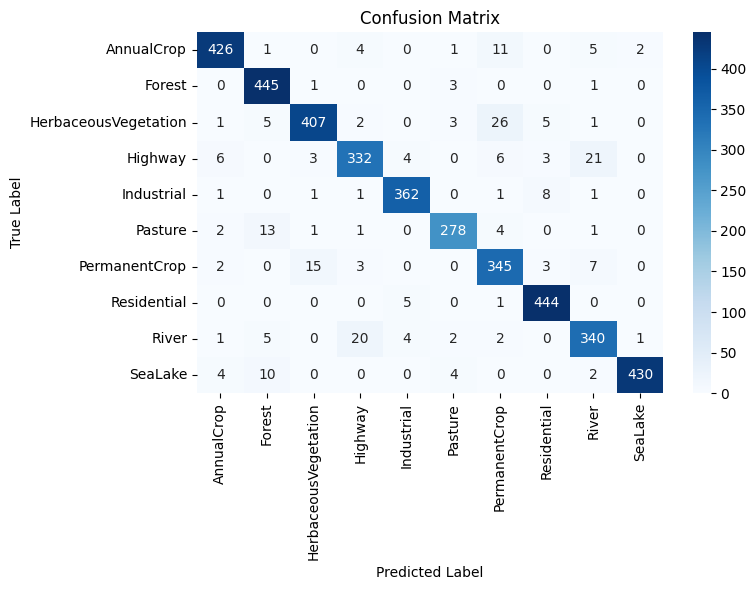


Classification Report:

                      precision    recall  f1-score   support

          AnnualCrop     0.9616    0.9467    0.9541       450
              Forest     0.9290    0.9889    0.9580       450
HerbaceousVegetation     0.9509    0.9044    0.9271       450
             Highway     0.9146    0.8853    0.8997       375
          Industrial     0.9653    0.9653    0.9653       375
             Pasture     0.9553    0.9267    0.9408       300
       PermanentCrop     0.8712    0.9200    0.8949       375
         Residential     0.9590    0.9867    0.9726       450
               River     0.8971    0.9067    0.9019       375
             SeaLake     0.9931    0.9556    0.9740       450

            accuracy                         0.9405      4050
           macro avg     0.9397    0.9386    0.9388      4050
        weighted avg     0.9412    0.9405    0.9405      4050

Test Accuracy: 0.9405
Test Loss: 0.0302


In [17]:
test_acc, test_loss, y_pred = evaluate_model(model, test_generator, list(test_generator.class_indices.keys()))
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

***
#### **Plot Training Process**

In [21]:
def plot_training_curves(history, test_acc=0):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    epochs_range = range(len(acc))
    phase2epoch = 20
    plt.figure(figsize=(14, 5))

    plt.plot(epochs_range, acc, label='Train Acc')
    plt.plot(epochs_range, val_acc, label='Val Acc')
    plt.axhline(y=test_acc, linestyle='--', color='green', label=f'Test Acc: {test_acc:.2f}')
    plt.axvspan(
        phase2epoch, len(epochs_range) - 1,    
        color='skyblue',                   
        alpha=0.20,                    
        label='Fine-Tuning Phase'      
    )    
    plt.title('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

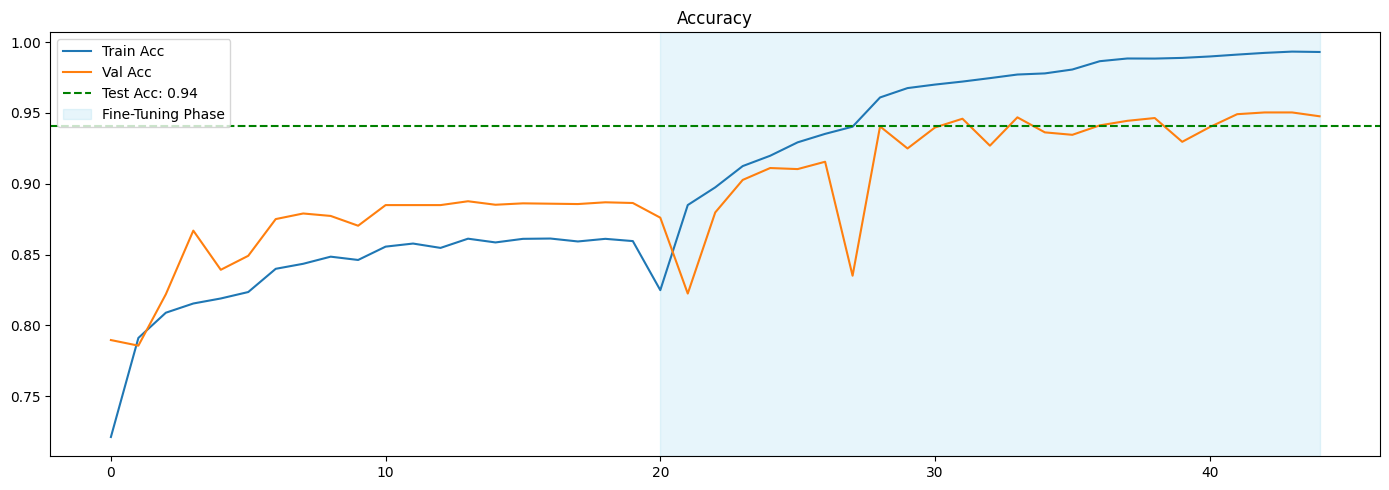

In [22]:
plot_training_curves(history, test_acc=test_acc)

***
#### Pick **Random** Image as test

1/1 [==============================] - 0s 15ms/step


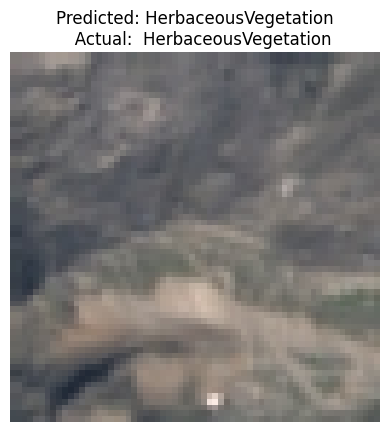

In [23]:
basefolder = dataset_root / "EuroSAT_RGB_split"
class_names = list(test_generator.class_indices.keys())

all_image_paths = []

for split_dir in os.listdir(basefolder):
    split_path = os.path.join(basefolder, split_dir)
    if os.path.isdir(split_path):
        for class_dir in os.listdir(split_path):
            class_path = os.path.join(split_path, class_dir)
            if os.path.isdir(class_path):
                for fname in os.listdir(class_path):
                    if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                        full_path = os.path.join(class_path, fname)
                        all_image_paths.append(full_path)


random_image_path = random.choice(all_image_paths)
image_type = random_image_path.split("\\")[-1].split("_")[0]

img = cv2.imread(random_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #type: ignore
img_resized = cv2.resize(img, image_size)
img_array = np.expand_dims(img_resized, axis=0) / 255.0  # normalize

pred = model.predict(img_array)
pred_class = class_names[np.argmax(pred)]

plt.imshow(img)
plt.title(f"Predicted: {pred_class}\n   Actual:  {image_type}")
plt.axis('off')
plt.show()